In [2]:
###open cv
pip install opencv-python

In [5]:
import pandas as pd
import tensorflow as tf
import cv2 ###open cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
metadata = pd.read_csv('/Users/kitty.mad/code/Kriskitt/melanoma_detector/data/metadata/metadata.csv')

In [8]:
### 1 alto / 0 bajo
def label_risk(row):
    if row['diagnostic'] in ['SCC', 'BCC', 'MEL']:
        return 1
    else:
        return 0

metadata['risk_label'] = metadata.apply(label_risk, axis=1)
pd.DataFrame(metadata['risk_label'])

,risk_label
0,0
1,1
2,0
3,0
4,1
...,...
2293,0
2294,1
2295,0
2296,1


In [9]:
##trains, test, vals
train_df, temp_df = train_test_split(metadata, test_size=0.3, stratify=metadata['risk_label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['risk_label'])

In [23]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalizar
    return image


In [31]:
def create_dataset(metadata, img_folder):
    img_paths = metadata['img_id'].apply(lambda x: f"{img_folder}/{x}").values
    labels = metadata['risk_label'].values
    images = []
    processed_labels = []
    for img_path, label in zip(img_paths, labels):
        image = preprocess_image(img_path)
        images.append(image)
        processed_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, processed_labels))

In [32]:
img_folder = '/Users/kitty.mad/code/Kriskitt/melanoma_detector/data/images'

In [33]:
train_ds = create_dataset(train_df, img_folder).batch(32).shuffle(100)
val_ds = create_dataset(val_df, img_folder).batch(32)
test_ds = create_dataset(test_df, img_folder).batch(32)

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet') ##investigar pretrained
base_model.trainable = False

In [35]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
es_callback = EarlyStopping(monitor='val_recall', patience=5, mode='max')

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es_callback]
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 353ms/step - loss: 0.8120 - recall: 0.5368 - val_loss: 0.5545 - val_recall: 0.8293
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - loss: 0.5441 - recall: 0.6760 - val_loss: 0.5040 - val_recall: 0.7561
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - loss: 0.4952 - recall: 0.6993 - val_loss: 0.5185 - val_recall: 0.7988
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 0.4393 - recall: 0.7537 - val_loss: 0.4887 - val_recall: 0.8598
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - loss: 0.4190 - recall: 0.7951 - val_loss: 0.5209 - val_recall: 0.8720
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - loss: 0.4006 - recall: 0.7752 - val_loss: 0.4844 - val_recall: 0.7561
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step - loss: 0.4058 - recall: 0.7789 - val_loss: 0.4880 - val_recall: 0.7073
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step - loss: 0.3657 - recall: 0.7816 - val_loss: 0.4763 - val_recall:

In [40]:
evaluation = model.evaluate(test_ds)
print("Evaluación en conjunto de prueba:", evaluation)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - loss: 0.5019 - recall: 0.7103
Evaluación en conjunto de prueba: [0.5123416185379028, 0.6809815764427185]


In [48]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model Recall')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

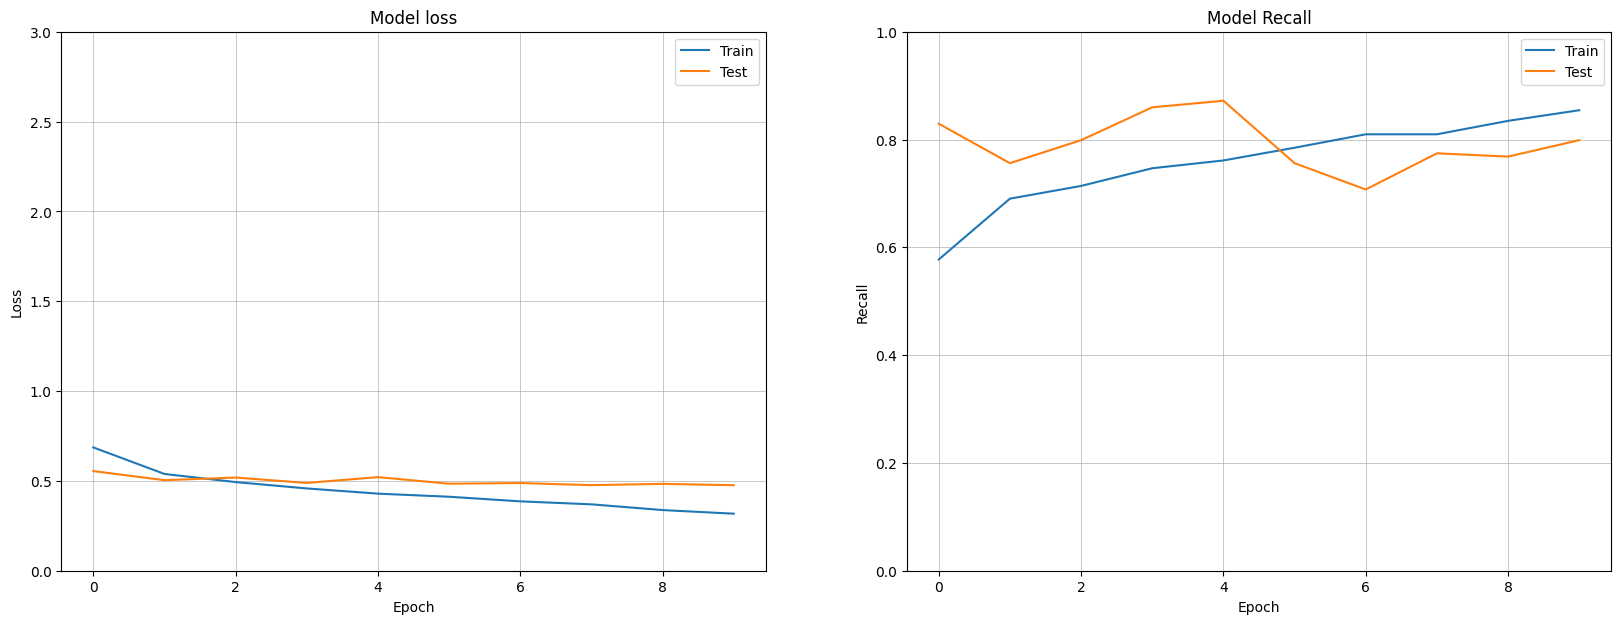

In [45]:
plot_loss_accuracy(history)

In [46]:
def predict_image(img_path):
    image = preprocess_image(img_path)
    image = tf.expand_dims(image, axis=0)  # Agregar dimensión batch
    prediction = model.predict(image)
    risk = "Alto riesgo" if prediction[0][0] > 0.5 else "Bajo riesgo"
    return risk

In [47]:
new_input = '/Users/kitty.mad/code/Kriskitt/melanoma_detector/data/upload/testtest_2.jpg'
resultado = predict_image(new_input)
print(f"La predicción para la imagen es: {resultado}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
La predicción para la imagen es: Alto riesgo
